# Summary of this notebook

In the [last notebook](01_download_tfrecords.ipynb), we downloaded the satellite image data corresponding to the locations of the DHS survey data from which the wealth index estimates were derived.  These data were downloaded in the form of `.tfrecord.gz` files (GZipped TensorFlow record files).  In this notebook, we extract the image data (and non-image data) from these `.tfrecord.gz` files and export the images as `.npy` Numpy arrays for later use.  We also export the non-image data as `.csv` files, with the indices of the rows in these `.csv` files sharing their names with the individual `.npy` satellite images.

In [ ]:
#If using Google Colab and Google Drive, run the following commands

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#REPLACE THIS COMMAND WITH THE APPROPRIATE PATH TO THE "code" FOLDER ON YOUR GOOGLE DRIVE
%cd ./drive/MyDrive/poverty_project/group_project/code

/content/drive/MyDrive/poverty_project/group_project/code


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage import io

from pprint import pprint

import itertools

from os import listdir
from os.path import isfile, join

from sklearn.model_selection import train_test_split

## Helper functions adapted from Yeh et al. (2020)'s [repository](https://github.com/sustainlab-group/africa_poverty)

In [ ]:
def parse_record_str(record_str: str):
    '''Parses a record str and returns the feature map.

    Args
    - record_str: str, binary representation of Example message
    '''
    # parse binary string into Example message
    ex = tf.train.Example.FromString(record_str)
    features = ex.features  # get Features message within the Example
    feature_map = features.feature  # get mapping from feature name strings to Feature
    return feature_map

In [ ]:
def get_all_feature_maps(tfrecord_path: str):
    '''Gets feature_map dict of all TFRecords in a TFRecord file.

    Args
    - tfrecord_path: str, path to a TFRecord file with GZIP compression

    Returns
    - a list of protobuf maps from feature name strings to Feature
    (one map for each record)
    '''
    # Create an iterator over the TFRecords file. The iterator yields
    # the binary representations of Example messages as strings.
    options = tf.io.TFRecordOptions(compression_type='GZIP')
    iterator = tf.compat.v1.io.tf_record_iterator(tfrecord_path, options=options)

    # get the first Example stored in the TFRecords file
    output = []
    for record_str in iterator:
        feature_map = parse_record_str(record_str)
        output.append(feature_map)
    
    return output

In [ ]:
def get_feature_types(feature_map):
    '''Gets the types and shapes of each feature in a given feature_map.

    Args
    - feature_map: protobuf map from feature name strings to Feature

    Returns
    - feature_types: dict, maps feature names (str) to tuple of (ft_type, ft_shape)
    '''
    # use the WhichOneof() method on messages with `oneof` fields to
    # determine the type of the field
    feature_types = {}
    for name in feature_map.keys():
        ft_type = feature_map[name].WhichOneof('kind')
        ft_shape = np.array(feature_map[name].__getattribute__(ft_type).value).shape
        feature_types[name] = (ft_type, ft_shape)
    return feature_types

# Get images and metadata from a tfrecord.gz a file

In [ ]:
tfrecord_path = '../data/dhs_tfrecords_raw/angola_2015_00.tfrecord.gz'

feature_maps = get_all_feature_maps(tfrecord_path)


print(f'Number of observations: {len(feature_maps)}')
print(f'TFRecord path: {tfrecord_path}')

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Number of observations: 625
TFRecord path: ../data/dhs_tfrecords_raw/angola_2015_00.tfrecord.gz


## Get all data from a single observation

In [ ]:
#Specify any index number less than the number of observations
#that was printed by the cell above
ind = 123

feature_types = get_feature_types(feature_maps[ind])
print('Features and types:')
pprint(feature_types)

Features and types:
{'BLUE': ('float_list', (65025,)),
 'GREEN': ('float_list', (65025,)),
 'LAT': ('float_list', (65025,)),
 'LON': ('float_list', (65025,)),
 'NIGHTLIGHTS': ('float_list', (65025,)),
 'NIR': ('float_list', (65025,)),
 'RED': ('float_list', (65025,)),
 'SWIR1': ('float_list', (65025,)),
 'SWIR2': ('float_list', (65025,)),
 'TEMP1': ('float_list', (65025,)),
 'country': ('bytes_list', (1,)),
 'households': ('float_list', (1,)),
 'lat': ('float_list', (1,)),
 'lon': ('float_list', (1,)),
 'system:index': ('bytes_list', (1,)),
 'urban_rural': ('float_list', (1,)),
 'wealthpooled': ('float_list', (1,)),
 'year': ('float_list', (1,))}


### Get non-image information

In [ ]:
#This feature does not capture any useful information; it's just the index of
#this observation within the single .tfrecord.gz file we happened to load.
#It is not a global index across all .tfrecord.gz files.
feature_maps[ind]['system:index'].bytes_list.value

[b'123']

In [ ]:
country_bytestring = feature_maps[ind]['country'].bytes_list.value[0]
country = country_bytestring.decode("utf-8")
country

'angola'

In [ ]:
year = feature_maps[ind]['year'].float_list.value[0]
year

2015.0

In [ ]:
wealth_index = feature_maps[ind]['wealthpooled'].float_list.value[0]
wealth_index

1.9558433294296265

In [ ]:
is_urban = feature_maps[ind]['urban_rural'].float_list.value[0]
is_urban

1.0

In [ ]:
households = feature_maps[ind]['households'].float_list.value[0]
households

21.0

In [ ]:
latitude = feature_maps[ind]['lat'].float_list.value[0]
latitude

-5.593386173248291

In [ ]:
longitude = feature_maps[ind]['lon'].float_list.value[0]
longitude

12.206088066101074

### Get image information

In [ ]:
img_channels = ['RED','BLUE','GREEN', 'LAT', 'LON', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1', 'NIGHTLIGHTS']
non_rgb_channels = [x for x in img_channels if x not in ['RED','GREEN','BLUE'] ]

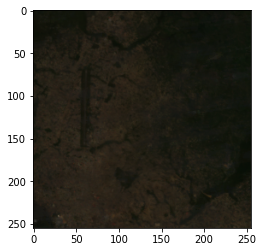

In [ ]:
#Display RGB image
blues = np.asarray([feature_maps[ind]['BLUE'].float_list.value[i] for i in range(65025)])
reds = np.asarray([feature_maps[ind]['RED'].float_list.value[i] for i in range(65025)])
greens = np.asarray([feature_maps[ind]['GREEN'].float_list.value[i] for i in range(65025)])

blues = blues.reshape(255,255)
reds = reds.reshape(255,255)
greens = greens.reshape(255,255)

img_array = np.stack([reds, greens, blues], axis=2)

plt.imshow(img_array)

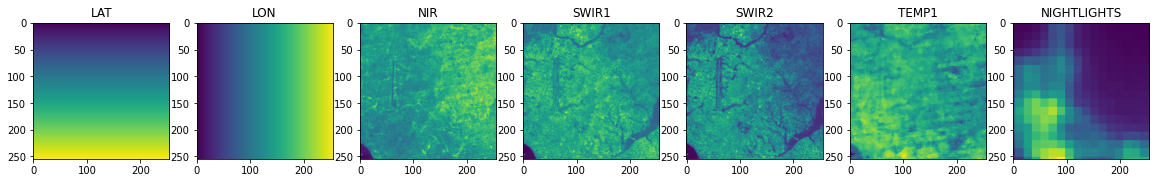

In [ ]:
#Display other image channels
fig, ax = plt.subplots(1,7, figsize=(20,20))

for i, channel in enumerate(non_rgb_channels):
  locals()[channel] = np.asarray([feature_maps[ind][channel].float_list.value[i] for i in range(65025)])
  locals()[channel] = locals()[channel].reshape(255,255)

  ax[i].imshow(locals()[channel])
  ax[i].set_title(channel)

The `LAT` and `LON` data are just the latitude and longitude of each point in the image, scaled so that they are all between 0 and 1.  Almost all of the time, the "LAT" and "LON" images above are just parallel lines running horizontally (resp. vertically) across the image, increasing in intensity as one moves down (resp. right) across the image.  In some cases, though, there is a slight "tilt" to these lines, meaning that the satellite took an image from a bit of an angle.

We do not want to train the model on these data, as it might learn to guess the wealth of a location based *not* on the actual features of the image but instead based on knowing the angle of the photo the satellite was able to take - that is, based on knowing something about *which part of the world the image comes from* rather than based on things actually present in the image.

For these reasons, we will discard the `LAT` and `LON` information when we export everything.

# Export all images and metadata from a single `.tfrecord.gz` file

In [ ]:
def export_tfrecord_as_images_and_df(input_directory, filename, img_output_dir, df_output_dir):
    '''
    Inputs:
    -input_directory: Path to folder containing .tfrecord.gz file to be processed
    -filename: Name of file to be processed (do NOT include a '/' or .tfrecord.gz)
    -img_output_dir: Path to folder to output "images" (8-channel .npy arrays) to
    -df_output_dir: Path to folder in which to output non-image data as a dataframe

    Extracts the 8 image channels from each record in the given .tfrecord.gz
      file (ignores "LAT" and "LON" channels).  The name of each "image"
      (8-channel array) will be the same as the inputted filename but with an
      appended '_[indexnumber].npy' where [indexnumber] is the index of that
      image in the inputted .tfrecord.gz file.

      Also extracts the non-image data in the form of a dataframe.  The indices
      of the outputted dataframe will be the names of the .npy files outputted
      (so that they can easily be matched to their non-image data).  The
      outputted dataframe will be saved in the df_output_dir and with the same
      filename as the inputted .tfrecord.gz file (except as a .csv).
    '''
    tfrecord_path = f"{input_directory}/{filename}.tfrecord.gz"
    feature_maps = get_all_feature_maps(tfrecord_path)

    #Do not extract the LAT and LON channels
    channels = ['RED','GREEN','BLUE','NIR', 'SWIR1', 'SWIR2', 'TEMP1', 'NIGHTLIGHTS']

    results_dict = {}

    for ind in range(len(feature_maps)):
        results_dict[ind]={}

        #Extract non-image features
        country_bytestring = feature_maps[ind]['country'].bytes_list.value[0]
        results_dict[ind]['country'] = country_bytestring.decode("utf-8")
        results_dict[ind]['year'] = feature_maps[ind]['year'].float_list.value[0]
        results_dict[ind]['wealth_index'] = feature_maps[ind]['wealthpooled'].float_list.value[0]
        results_dict[ind]['is_urban'] = feature_maps[ind]['urban_rural'].float_list.value[0]
        results_dict[ind]['households'] = feature_maps[ind]['households'].float_list.value[0]
        results_dict[ind]['latitude'] = feature_maps[ind]['lat'].float_list.value[0]
        results_dict[ind]['longitude'] = feature_maps[ind]['lon'].float_list.value[0]

        #Create an index to be used for the outputted dataframe
        results_dict[ind]['index'] = f"{filename}_{ind}"


        #Extract image channels and save them as Numpy arrays
        channel_arrays_list = []
        for channel in channels:

            #Extract info as 1-D array and reshape into 2-D array
            channel_arrays_list.append( np.asarray([feature_maps[ind][channel].float_list.value[i] for i in range(65025)]).reshape(255,255) )

            #locals()[channel] = np.asarray([feature_maps[ind][channel].float_list.value[i] for i in range(65025)])
            #locals()[channel] = locals()[channel].reshape(255,255)

        #Stack the 8 channels into one "image" array
        img_array = np.stack(channel_arrays_list, axis=2)
        #img_array = np.stack([RED, GREEN, BLUE, NIR, SWIR1, SWIR2, TEMP1, NIGHTLIGHTS], axis=2)

        #Save the image array to the given output directory
        np.save(f"{img_output_dir}/{filename}_{ind}.npy" , img_array)


    #Turn the non-image data into a dataframe
    df = pd.DataFrame(results_dict).T
    df.set_index('index', inplace=True)
    df.to_csv(f"{df_output_dir}/{filename}.csv", index_label='index')


## Using the function to process a single `.tfrecord.gz` file

In [ ]:
input_directory = '../data/dhs_tfrecords_raw'
filename = 'angola_2011_00'

img_output_dir = '../data/dhs_images'
df_output_dir = '../data/dhs_non_image_data'

In [ ]:
#Use the function to process the angola_2011_00.tfrecord.gz file
export_tfrecord_as_images_and_df(input_directory, filename, img_output_dir, df_output_dir)

In [ ]:
#Check the non-image data
df = pd.read_csv(f"{df_output_dir}/{filename}.csv", index_col='index')
df.head()

,country,year,wealth_index,is_urban,households,latitude,longitude
index,,,,,,,
angola_2011_00_0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922
angola_2011_00_1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494
angola_2011_00_2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085
angola_2011_00_3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711
angola_2011_00_4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748


### Reproduce an image

In [ ]:
#Reproduce image with index 1
img_array = np.load(f"{img_output_dir}/{filename}_{27}.npy")

#Should be a 255x255 image with 8 channels
img_array.shape

(255, 255, 8)

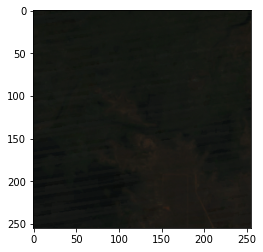

In [ ]:
#Show only the RGB channels
plt.imshow(img_array[:,:,0:3])

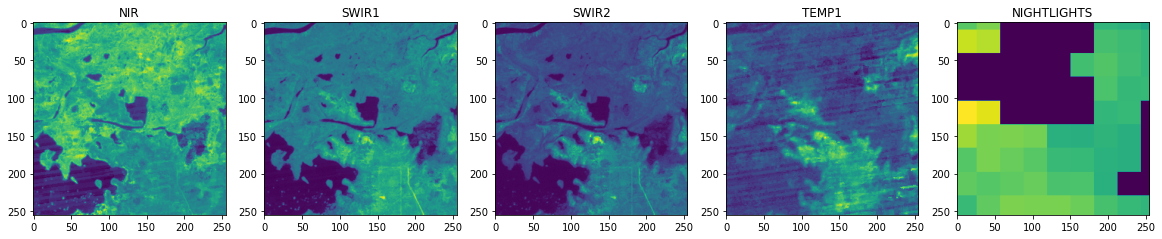

In [ ]:
#Display other image channels
non_rgb_channels = ['NIR', 'SWIR1', 'SWIR2', 'TEMP1', 'NIGHTLIGHTS']
fig, ax = plt.subplots(1,5, figsize=(20,20))

for i, channel in enumerate(non_rgb_channels):
  ax[i].imshow(img_array[:,:,i+3])
  ax[i].set_title(channel)

### The `TEMP1` and `NIGHTLIGHTS` channels are not on the same 0-to-1 scale as the other variables


In [ ]:
#NIGHTLIGHTS
img_array[0:5, 0:5, 7]

array([[4.71463203, 4.71463203, 4.71463203, 4.71463203, 4.71463203],
       [4.71463203, 4.71463203, 4.71463203, 4.71463203, 4.71463203],
       [4.71463203, 4.71463203, 4.71463203, 4.71463203, 4.71463203],
       [4.71463203, 4.71463203, 4.71463203, 4.71463203, 4.71463203],
       [4.71463203, 4.71463203, 4.71463203, 4.71463203, 4.71463203]])

In [ ]:
#TEMP1
img_array[0:5, 0:5, 6]

array([[294.5       , 294.20001221, 294.20001221, 293.8999939 ,
        294.5       ],
       [294.5       , 294.5       , 293.8999939 , 293.8999939 ,
        293.8999939 ],
       [294.5       , 294.5       , 294.5       , 295.        ,
        294.75      ],
       [295.        , 295.        , 295.        , 295.        ,
        295.        ],
       [295.        , 295.        , 295.        , 295.        ,
        295.        ]])

In [ ]:
#SWIR2
img_array[0:5, 0:5, 5]

array([[0.0859 , 0.08455, 0.08375, 0.0889 , 0.0895 ],
       [0.0808 , 0.0822 , 0.08775, 0.0896 , 0.0972 ],
       [0.0869 , 0.0843 , 0.0875 , 0.0709 , 0.0859 ],
       [0.0843 , 0.0843 , 0.0817 , 0.0787 , 0.0725 ],
       [0.08815, 0.0908 , 0.0808 , 0.081  , 0.081  ]])

In [ ]:
#SWIR1
img_array[0:5, 0:5, 4]

array([[0.15989999, 0.16525   , 0.17290001, 0.1734    , 0.1846    ],
       [0.1734    , 0.17460001, 0.18005   , 0.18179999, 0.1934    ],
       [0.1846    , 0.18539999, 0.1811    , 0.1769    , 0.1776    ],
       [0.17550001, 0.1806    , 0.1728    , 0.1744    , 0.1776    ],
       [0.17945001, 0.18295   , 0.1812    , 0.1706    , 0.1635    ]])

In [ ]:
#NIR
img_array[0:5, 0:5, 3]

array([[0.26069999, 0.23944999, 0.25189999, 0.2388    , 0.25760001],
       [0.28760001, 0.27790001, 0.27474999, 0.2465    , 0.23800001],
       [0.28760001, 0.2782    , 0.2782    , 0.27410001, 0.25690001],
       [0.30430001, 0.30419999, 0.2999    , 0.26605001, 0.2509    ],
       [0.29914999, 0.29484999, 0.2552    , 0.23899999, 0.23370001]])

# There are some problematic images

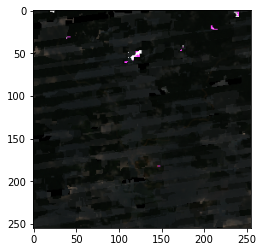

In [ ]:
#A few images possibly have issues... such as number 66
img_array = np.load(f"{img_output_dir}/{filename}_{66}.npy")

plt.imshow(img_array[:,:,0:3])

This image contains some RGB pixel values that are greater than 1.  How many other images in our data set do?

In [ ]:
len(df)

230

In [ ]:
#How many have bad RGB values?
for img_num in range(len(df)):
    img_array = np.load(f"{img_output_dir}/{filename}_{img_num}.npy")

    for x,y,z in itertools.product(range(255),range(255),range(3)):
        if img_array[x, y, z]>1:
          print(f"Image with bad RGB: Number {img_num}")
          break
    

Bad image: Number 66
Bad image: Number 67


So only two of our 230 images have bad RGB channels.  What about the other image channels (other than `TEMP1` and `NIGHTLIGHTS`)?

In [ ]:
#How many have bad NIR, SWIR1, or SWIR2 values?
bad_images=[]

for img_num in range(len(df)):
    img_array = np.load(f"{img_output_dir}/{filename}_{img_num}.npy")

    for x,y,z in itertools.product(range(255),range(255),range(3,6)):
        if img_array[x, y, z]>1:
          bad_images.append(img_num)
          break

len(bad_images)

46

# Figuring out what these weird pixel value scales mean, and what to do about them

## Finding the pixel value scale of the images

In [ ]:
results = {}

#Loop over all images that were created from the single tfrecord.gz file
for i in range(len(df)):
    results[i] = {}
    img_array = np.load(f"{img_output_dir}/{filename}_{i}.npy")

    #For each of the 8 channels, find the minimum and maximum pixel values taken on in that channel
    for channel in range(8):
        results[i][f"{channel}_min"] = np.min(img_array[:,:,channel])
        results[i][f"{channel}_max"] = np.max(img_array[:,:,channel])

res_df = pd.DataFrame(results).T
res_df.head()

,0_min,0_max,1_min,1_max,2_min,2_max,3_min,3_max,4_min,4_max,5_min,5_max,6_min,6_max,7_min,7_max
0,0.0207,0.3772,0.03180,0.3375,0.03550,0.25290,0.0170,0.41155,0.00700,0.52955,0.00490,0.45280,291.299988,302.700012,5.459832,114.975204
1,0.0225,0.3912,0.03465,0.3375,0.03715,0.25290,0.0188,0.46960,0.00780,0.60865,0.00620,0.53670,291.299988,302.700012,15.773443,114.975204
2,0.0356,0.3616,0.06780,0.3156,0.05495,0.23645,0.0201,0.41050,0.00875,0.57675,0.00585,0.50210,292.899994,305.450012,5.061296,139.326385
3,0.0196,0.3666,0.03030,0.3156,0.03330,0.23720,0.0136,0.42000,0.00490,0.55805,0.00240,0.50155,292.399994,304.149994,11.947468,139.326385
4,0.0210,0.3616,0.04140,0.3156,0.04140,0.23645,0.0153,0.41050,0.00620,0.55970,0.00260,0.48155,292.399994,304.399994,9.994291,139.326385


In [ ]:
res_df.min()

0_min      0.00000
0_max      0.11325
1_min      0.00000
1_max      0.09145
2_min      0.00000
2_max      0.06750
3_min      0.00000
3_max      0.28140
4_min      0.00000
4_max      0.30165
5_min      0.00000
5_max      0.21305
6_min      0.00000
6_max    296.50000
7_min      0.00000
7_max      0.00000
dtype: float64

So all of the channels have a *minimum* value that is no smaller than 0.  What about their maximum values?

In [ ]:
res_df.max()

0_min      0.099800
0_max      1.095100
1_min      0.089300
1_max      1.071300
2_min      0.066000
2_max      1.069550
3_min      0.185900
3_max      0.559900
4_min      0.156500
4_max      2.000000
5_min      0.087000
5_max      1.041350
6_min    296.799988
6_max    313.200012
7_min    283.109894
7_max    538.168457
dtype: float64

So channels 0, 1 and 2 (RGB) have maximum values that are only *slightly* above 1.  As we saw, only 2 of the 230 observations had even one "bad RGB pixel" (i.e., value >1).  However, 46 of the images had a "bad IR pixel" (i.e., channel 3, 4, or 5 has a pixel > 1).  Meanwhile, channels 6 and 7 (TEMP1 and NIGHTLIGHTS) appear to be on a scale entirely of their own, ranging from 0 to some large positive values (at least 313 and 538, respectively).

Furthermore, the "bad IR pixels" don't seem to be so bad (i.e., their maxima are not *much* bigger than 1), except for channel 4, which attains a maximum value of 2.  Is this "2" an outlier, or are values much bigger than 1 common in channel 4?  Let's find out:

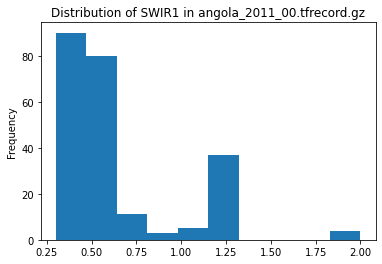

In [ ]:
res_df['4_max'].plot(kind='hist', title = f'Distribution of SWIR1 in {filename}.tfrecord.gz')

So it appears that values near 2 are rare, but values significantly above 1 are not uncommon.  This suggests that we should simply rescale this whole variable by a factor of .5 in order to make all its pixel values fall between 0 and 1.  Let's see what happens when we do this to an example image:

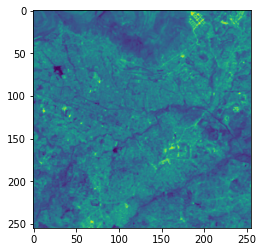

In [ ]:
img_array = np.load(f"{img_output_dir}/{filename}_{123}.npy")

#Original picture, before rescaling
channel4 = img_array[:,:,4]
plt.imshow(channel4)

In [ ]:
#What are the values stored in this array?
channel4

array([[0.2383    , 0.23450001, 0.24950001, ..., 0.27805001, 0.255     ,
        0.2447    ],
       [0.2529    , 0.2586    , 0.25839999, ..., 0.27724999, 0.29624999,
        0.2872    ],
       [0.25709999, 0.27059999, 0.26460001, ..., 0.27884999, 0.31384999,
        0.33605   ],
       ...,
       [0.2606    , 0.24600001, 0.24879999, ..., 0.3008    , 0.2956    ,
        0.31      ],
       [0.2379    , 0.2534    , 0.26409999, ..., 0.30419999, 0.30575001,
        0.31619999],
       [0.21340001, 0.2322    , 0.2782    , ..., 0.31119999, 0.303     ,
        0.31209999]])

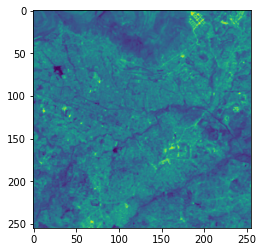

In [ ]:
rescaled_channel4 = img_array[:,:,4]/2
plt.imshow(rescaled_channel4)

In [ ]:
#What are the values stored in this array?
rescaled_channel4

array([[0.11915   , 0.11725   , 0.12475   , ..., 0.139025  , 0.1275    ,
        0.12235   ],
       [0.12645   , 0.1293    , 0.1292    , ..., 0.138625  , 0.14812499,
        0.1436    ],
       [0.12854999, 0.1353    , 0.1323    , ..., 0.13942499, 0.15692499,
        0.168025  ],
       ...,
       [0.1303    , 0.123     , 0.1244    , ..., 0.1504    , 0.1478    ,
        0.155     ],
       [0.11895   , 0.1267    , 0.13204999, ..., 0.1521    , 0.15287501,
        0.15809999],
       [0.1067    , 0.1161    , 0.1391    , ..., 0.1556    , 0.1515    ,
        0.15605   ]])

The rescaled and non-rescaled images look the same, even though their arrays are different!  This suggests that, when an image is imported, exported, or viewed with `matplotlib`, the image's pixels are automatically rescaled to be between 0 and 1.

Let's test this hypothesis by exporting and re-importing a couple images.

## Exporting an array as an image then re-importing

In [ ]:
#Save the .5-scaled image
img = rescaled_channel4
img_save_loc = '../data/test_images'
img_name = 'scaled'
plt.imsave(f"{img_save_loc}/{img_name}.png", img)

In [ ]:
#Load it in
read_in = imread(f"{img_save_loc}/{img_name}.png")
type(read_in)

numpy.ndarray

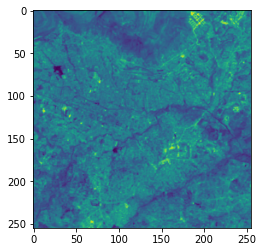

In [ ]:
plt.imshow(read_in)

In [ ]:
#What are the values stored in the image?
read_in

array([[[0.22352941, 0.33333334, 0.54509807, 1.        ],
        [0.22745098, 0.3254902 , 0.54509807, 1.        ],
        [0.21176471, 0.3529412 , 0.54901963, 1.        ],
        ...,
        [0.1882353 , 0.40784314, 0.5529412 , 1.        ],
        [0.20784314, 0.3647059 , 0.54901963, 1.        ],
        [0.21568628, 0.34509805, 0.54901963, 1.        ]],

       [[0.20784314, 0.36078432, 0.54901963, 1.        ],
        [0.20392157, 0.37254903, 0.5529412 , 1.        ],
        [0.20392157, 0.37254903, 0.5529412 , 1.        ],
        ...,
        [0.1882353 , 0.40392157, 0.5529412 , 1.        ],
        [0.17254902, 0.4392157 , 0.5568628 , 1.        ],
        [0.18039216, 0.42352942, 0.5568628 , 1.        ]],

       [[0.20392157, 0.36862746, 0.5529412 , 1.        ],
        [0.19215687, 0.39215687, 0.5529412 , 1.        ],
        [0.2       , 0.38039216, 0.5529412 , 1.        ],
        ...,
        [0.1882353 , 0.40784314, 0.5529412 , 1.        ],
        [0.16078432, 0.470588

In [ ]:
read_in.shape

(255, 255, 4)

Sadly this export type seems to be copying the single channel 3 times over, and adding a 4th channel.  However, it *does* seem to be rescaling everything to be between 0 and 1.

In [ ]:
#Save the non-scaled image
img = channel4
img_save_loc = '../data/test_images'
img_name = 'original'
#io.imsave(f"{img_save_loc}/{img_name}.tiff", img.astype(np.uint16))
plt.imsave(f"{img_save_loc}/{img_name}.png", img)

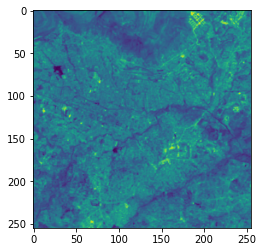

In [ ]:
#Load it in
read_in = imread(f"{img_save_loc}/{img_name}.png")
plt.imshow(read_in)

In [ ]:
#What are the values stored in the image?
read_in

array([[[0.22352941, 0.33333334, 0.54509807, 1.        ],
        [0.22745098, 0.3254902 , 0.54509807, 1.        ],
        [0.21176471, 0.3529412 , 0.54901963, 1.        ],
        ...,
        [0.1882353 , 0.40784314, 0.5529412 , 1.        ],
        [0.20784314, 0.3647059 , 0.54901963, 1.        ],
        [0.21568628, 0.34509805, 0.54901963, 1.        ]],

       [[0.20784314, 0.36078432, 0.54901963, 1.        ],
        [0.20392157, 0.37254903, 0.5529412 , 1.        ],
        [0.20392157, 0.37254903, 0.5529412 , 1.        ],
        ...,
        [0.1882353 , 0.40392157, 0.5529412 , 1.        ],
        [0.17254902, 0.4392157 , 0.5568628 , 1.        ],
        [0.18039216, 0.42352942, 0.5568628 , 1.        ]],

       [[0.20392157, 0.36862746, 0.5529412 , 1.        ],
        [0.19215687, 0.39215687, 0.5529412 , 1.        ],
        [0.2       , 0.38039216, 0.5529412 , 1.        ],
        ...,
        [0.1882353 , 0.40784314, 0.5529412 , 1.        ],
        [0.16078432, 0.470588

This means that both the rescaled and non-rescaled images are (other than perhaps some rounding errors) *exactly the same* after being exported as images.

What happens if we export one of the TEMP1 or NIGHTLIGHTS channels (that had values much larger than 255 in them) and then re-import it?

### TEMP1 image

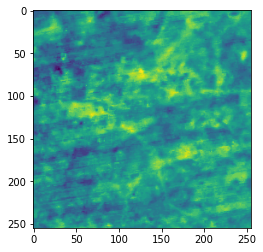

In [ ]:
img_array = np.load(f"{img_output_dir}/{filename}_{123}.npy")

#TEMP1 channel
channel6 = img_array[:,:,6]
plt.imshow(channel6)

In [ ]:
#What are the contents of the array?
channel6

array([[294.20001221, 294.20001221, 294.5       , ..., 297.8500061 ,
        297.70001221, 297.70001221],
       [294.20001221, 294.70001221, 294.70001221, ..., 298.        ,
        297.75      , 297.5       ],
       [294.70001221, 294.70001221, 295.        , ..., 297.75      ,
        297.5       , 297.1499939 ],
       ...,
       [295.54998779, 295.75      , 295.75      , ..., 297.5       ,
        297.29998779, 297.29998779],
       [296.        , 296.        , 296.3999939 , ..., 297.8999939 ,
        297.8999939 , 298.1000061 ],
       [295.75      , 296.        , 296.        , ..., 297.70001221,
        297.70001221, 297.8999939 ]])

In [ ]:
#Save the array as an image
img = channel6
img_save_loc = '../data/test_images'
img_name = 'channel6'
#io.imsave(f"{img_save_loc}/{img_name}.tiff", img.astype(np.uint16))
plt.imsave(f"{img_save_loc}/{img_name}.png", img)

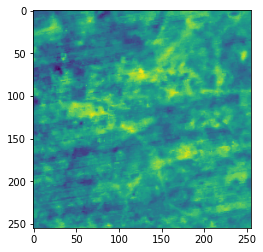

In [ ]:
#Load it in
read_in = imread(f"{img_save_loc}/{img_name}.png")
plt.imshow(read_in)

In [ ]:
#What are the contents of the read-in array?
read_in

array([[[0.23921569, 0.29803923, 0.5372549 , 1.        ],
        [0.23921569, 0.29803923, 0.5372549 , 1.        ],
        [0.22352941, 0.33333334, 0.54509807, 1.        ],
        ...,
        [0.14509805, 0.67058825, 0.5058824 , 1.        ],
        [0.13333334, 0.654902  , 0.5176471 , 1.        ],
        [0.13333334, 0.654902  , 0.5176471 , 1.        ]],

       [[0.23921569, 0.29803923, 0.5372549 , 1.        ],
        [0.21176471, 0.3529412 , 0.54901963, 1.        ],
        [0.21176471, 0.3529412 , 0.54901963, 1.        ],
        ...,
        [0.16078432, 0.6862745 , 0.49803922, 1.        ],
        [0.13725491, 0.65882355, 0.5137255 , 1.        ],
        [0.12156863, 0.6392157 , 0.5254902 , 1.        ]],

       [[0.21176471, 0.3529412 , 0.54901963, 1.        ],
        [0.21176471, 0.3529412 , 0.54901963, 1.        ],
        [0.19607843, 0.38431373, 0.5529412 , 1.        ],
        ...,
        [0.13725491, 0.65882355, 0.5137255 , 1.        ],
        [0.12156863, 0.639215

In [ ]:
read_in.shape

(255, 255, 4)

So all of the values (previously large numbers, often >255) have been rescaled to be between 0 and 1 for the purposes of this 1-channel image... but the single channel has been duplicated into 3 channels.  Let's check that it does the same with a NIGHTLIGHTS image:

### NIGHLIGHTS image

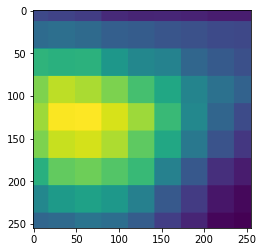

In [ ]:
img_array = np.load(f"{img_output_dir}/{filename}_{123}.npy")

#NIGHTLIGHTS channel
channel7 = img_array[:,:,7]
plt.imshow(channel7)

In [ ]:
#What are the contents of the array?
channel7

array([[29.16893387, 29.16893387, 29.16893387, ..., 16.73699379,
        16.73699379, 16.73699379],
       [29.16893387, 29.16893387, 29.16893387, ..., 16.73699379,
        16.73699379, 16.73699379],
       [29.16893387, 29.16893387, 29.16893387, ..., 16.73699379,
        16.73699379, 16.73699379],
       ...,
       [39.08704758, 39.08704758, 39.08704758, ...,  9.39489365,
         9.39489365,  9.39489365],
       [39.08704758, 39.08704758, 39.08704758, ...,  9.39489365,
         9.39489365,  9.39489365],
       [39.08704758, 39.08704758, 39.08704758, ...,  9.39489365,
         9.39489365,  9.39489365]])

In [ ]:
channel7.shape

(255, 255)

In [ ]:
#Save the array as an image
img = channel7
img_save_loc = '../data/test_images'
img_name = 'channel7'
#io.imsave(f"{img_save_loc}/{img_name}.tiff", img.astype(np.uint16))
plt.imsave(f"{img_save_loc}/{img_name}.png", img)

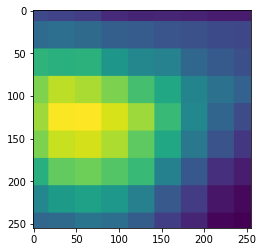

In [ ]:
#Load it in
read_in = imread(f"{img_save_loc}/{img_name}.png")
plt.imshow(read_in)

In [ ]:
#What are the contents of the read-in array?
read_in

array([[[ 64,  72, 134],
        [ 64,  72, 134],
        [ 64,  72, 134],
        ...,
        [ 75,  27, 111],
        [ 75,  27, 111],
        [ 75,  27, 111]],

       [[ 63,  73, 134],
        [ 63,  73, 134],
        [ 63,  73, 134],
        ...,
        [ 75,  27, 111],
        [ 75,  27, 111],
        [ 75,  27, 111]],

       [[ 62,  73, 135],
        [ 62,  73, 135],
        [ 62,  73, 135],
        ...,
        [ 72,  29, 111],
        [ 72,  29, 111],
        [ 72,  29, 111]],

       ...,

       [[ 49, 103, 141],
        [ 49, 103, 141],
        [ 49, 103, 141],
        ...,
        [ 68,   0,  83],
        [ 68,   0,  83],
        [ 68,   0,  83]],

       [[ 49, 103, 141],
        [ 49, 103, 141],
        [ 49, 103, 141],
        ...,
        [ 68,   0,  83],
        [ 68,   0,  83],
        [ 68,   0,  83]],

       [[ 49, 103, 141],
        [ 49, 103, 141],
        [ 49, 103, 141],
        ...,
        [ 68,   0,  83],
        [ 68,   0,  83],
        [ 68,   0,  83]]

In [ ]:
read_in.shape

(255, 255, 3)

So again, all of the values have been rescaled to be between 0 and 1 for the purposes of this 1-channel image.

# Summary of eveything we've learned

We've learned that, when exporting an array as a *single-channel* image, the values in the array are automatically rescaled to be between 0 and 1.  Hence, we do not need to worry about any of the non-RBG channels taking on "bad" values: we can simply export them as 1-channel images (in the form of `.png` files, which actually have 4 channels apparently).  But `keras` can always read these images in as single-channel images, saving time when training our models.

However, *we must make sure that there are no "bad" pixels (values > 1) in any of the RGB channels*, as RGB images are rendered on an *absolute* scale and not a relative one (hence, `matplotlib` does not automatically rescale the numeric values so that their limits are 0 and 1).  As we saw above, 2 of the 230 images in `angola_2011_00.tfrecord.gz` had some "bad RGB pixels" (namely, images numbers 66 and 67).  For example, image 66:

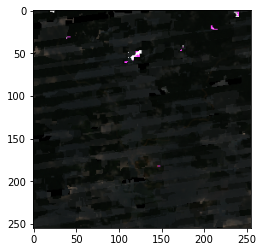

In [ ]:
#An image with some RGB pixel values > 1
img_array = np.load(f"{img_output_dir}/{filename}_{66}.npy")

plt.imshow(img_array[:,:,0:3])

# Our method for exporting images from `.tfrecord.gz` files

This all suggests a simple method for exporting all the image channels from the `.tfrecord.gz` files:

1. For each observation, check that none of the RBG pixels are "bad" (not between 0 and 1).  Skip these "bad" observations.
2. For every non-"bad" observation, export the RBG channels as a single RGB image (in `.jpg` format, with values between 0 and 255).  Then export all the other channels as individual single-channel images (in `.png` format, so that things automatically rescale to be between 0 and 1).

Furthermore, we will want to do the following things as we export our files:
3. Automatically split the data into `train`, `test`, and `val` directories so that `keras` has an easy time with things.
4. Within each of the `train`, `test` and `val` directories, split the images among two folders: folder `1` representing the poorest third of all villages (equivalent to `is_poorest==1` below), and folder `0` representing all other villages.

## A processing function that rules out bad RGB pixels

To figure out which villages both (a) have satellite images with no "bad" RGB pixels and (b) are/are not in the poorest third of villages, we will need to run some processing on *all* of the `.tfrecord.gz` files.  The function below does so: it exports the RGB + TEMP1 + NIGHTLIGHTS channels into 255x255x5 numpy arrays and saves them as `.npy` files.  It then compiles dataframes of all the non-image information contained in the `.tfrecord.gz` file (but only for those images we "kept" since they did not have bad RGB pixels).

In [ ]:
def export_good_images_and_df(input_directory, filename, img_output_dir, df_output_dir):
    '''
    NOTE: These "cleaned" outputs are saved WITH A DASH RATHER THAN AN
    UNDERSCORE as the final separator in the image file names and df indices.

    Inputs:
    -input_directory: Path to folder containing .tfrecord.gz file to be processed
    -filename: Name of file to be processed (do NOT include a '/' or .tfrecord.gz)
    -img_output_dir: Path to folder to output "images" (5-channel .npy arrays) to
    -df_output_dir: Path to folder in which to output non-image data as a dataframe

    Extracts the 5 image channels from each record in the given .tfrecord.gz
      file (ignores LAT, LON, NIR, SWIR1, & SWIR2 channels). The name of each "image"
      (5-channel array) will be the same as the inputted filename but with an
      appended '_[indexnumber].npy' where [indexnumber] is the index of that
      image in the inputted .tfrecord.gz file.

      Also extracts the non-image data in the form of a dataframe.  The indices
      of the outputted dataframe will be the names of the .npy files outputted
      (so that they can easily be matched to their non-image data).  The
      outputted dataframe will be saved in the df_output_dir and with the same
      filename as the inputted .tfrecord.gz file (except as a .csv).

      If any image has any "bad RGB pixels" (i.e. values not between 0 and 1),
      then that image is skipped.  It will not be outputted as an image file
      and it will not appear as a row in the outputted dataframe.
    '''
    tfrecord_path = f"{input_directory}/{filename}.tfrecord.gz"
    feature_maps = get_all_feature_maps(tfrecord_path)

    #Do not extract the LAT, LON, NIR, SWIR1, or SWIR2 channels
    channels = ['RED','GREEN','BLUE', 'TEMP1', 'NIGHTLIGHTS']

    non_img_features_dict = {'year':'year',
                            'wealth_index':'wealthpooled',
                            'is_urban':'urban_rural',
                            'households':'households',
                            'latitude':'lat',
                            'longitude':'lon'
        }

    results_dict = {}

    for ind in range(len(feature_maps)):
        #Reset our "we had a bad RGB pixel" breaker
        breaker=0

        #Extract image channels and save them as Numpy arrays
        channel_arrays_list = []
        for channel in channels:

            #Extract the RGB info
            if channel in ['RED','GREEN','BLUE']:
               #Extract only those pixels that have value between 0 and 1 (others are bad pixels)
               channel_pixels = [feature_maps[ind][channel].float_list.value[i] for i in range(65025) \
                                 if ((feature_maps[ind][channel].float_list.value[i] <= 1) \
                                 and (feature_maps[ind][channel].float_list.value[i] >= 0)) ]

               #If there are any bad pixels, skip this image
               if len(channel_pixels)<65025:
                  breaker = 1
                  break

            #For the TEMP1 and NIGHTLIGHTS channels, just extract the pixels
            else:
                channel_pixels = [feature_maps[ind][channel].float_list.value[i] for i in range(65025)]

            #Reshape into 2-D array and append to our list
            channel_array = np.asarray(channel_pixels)
            channel_arrays_list.append( channel_array.reshape(255,255) )

        #If we had any bad RGB pixels, just move to the next index (and in
        #particular, don't make a row for our dataframe)
        if breaker==1:
            continue

        #If the RGB channels are all fine:

        #Stack the 5 channels into one "image" array
        img_array = np.stack(channel_arrays_list, axis=2)

        #Save the image array to the given output directory
        np.save(f"{img_output_dir}/{filename}-{ind}.npy" , img_array)


        #Extract non-image features
        results_dict[ind]={}

        #Only fill in values if you can.  Fill the dataframe with NaN if the
        #non-image data doesn't exist for this image.
        try:
            country_bytestring = feature_maps[ind]['country'].bytes_list.value[0]
            results_dict[ind]['country'] = country_bytestring.decode("utf-8")
        except:
            pass


        for feature, feat_name in non_img_features_dict.items():
            try:
                results_dict[ind][feature] = feature_maps[ind][feat_name].float_list.value[0]
            except:
                pass


        #Create an index to be used for the outputted dataframe
        results_dict[ind]['index'] = f"{filename}-{ind}"


        
    #Turn the non-image data into a dataframe
    df = pd.DataFrame(results_dict).T
    df.set_index('index', inplace=True)
    df.to_csv(f"{df_output_dir}/{filename}.csv", index_label='index')


## Using the new "cleaned" function to process a single `.tfrecord.gz` file

In [ ]:
#Use the same .tfrecord.gz file as before
input_directory = '../data/dhs_tfrecords_raw'
filename = 'angola_2011_00'

#Output to the "cleaned" folders this time
img_output_dir = '../data/dhs_images_cleaned'
df_output_dir = '../data/dhs_non_image_data_cleaned'

In [ ]:
#Use the function to process the angola_2011_00.tfrecord.gz file
export_good_images_and_df(input_directory, filename, img_output_dir, df_output_dir)

In [ ]:
#Check the non-image data
df = pd.read_csv(f"{df_output_dir}/{filename}.csv", index_col='index')
df.head()

,country,year,wealth_index,is_urban,households,latitude,longitude
index,,,,,,,
angola_2011_00-0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922
angola_2011_00-1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494
angola_2011_00-2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085
angola_2011_00-3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711
angola_2011_00-4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, angola_2011_00-0 to angola_2011_00-229
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       228 non-null    object 
 1   year          228 non-null    float64
 2   wealth_index  228 non-null    float64
 3   is_urban      228 non-null    float64
 4   households    228 non-null    float64
 5   latitude      228 non-null    float64
 6   longitude     228 non-null    float64
dtypes: float64(6), object(1)
memory usage: 14.2+ KB


Recall that with the old version of the function, we had 230 observations, but observations numbers 66 and 67 had bad RGB pixels.  This new function did not export these values, and they don't appear in the dataframe:

In [ ]:
#We should NOT find observations numbers 66 and 67 this way
[s for s in df.index if ('66' in s) or ('67' in s)]

['angola_2011_00-166', 'angola_2011_00-167']

### Reproduce an image

In [ ]:
#Reproduce image with index angola_2011_00-1
img_array = np.load(f"{img_output_dir}/{filename}-{1}.npy")

#Should be a 255x255 image with 5 channels
img_array.shape

(255, 255, 5)

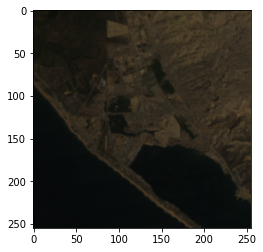

In [ ]:
#Show only the RGB channels
plt.imshow(img_array[:,:,0:3])

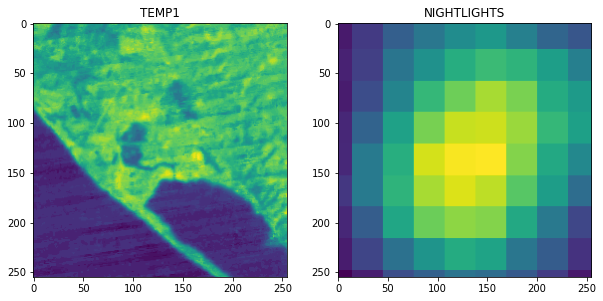

In [ ]:
#Display other image channels
non_rgb_channels = ['TEMP1', 'NIGHTLIGHTS']
fig, ax = plt.subplots(1,2, figsize=(10,10))

for i, channel in enumerate(non_rgb_channels):
  ax[i].imshow(img_array[:,:,i+3])
  ax[i].set_title(channel)

# Using the "cleaned" function to export all images and non-image data from ALL `tfrecord.gz` files

In [ ]:
#Location where the .tfrecord.gz files are
input_directory = '../data/dhs_tfrecords_raw'

#Locations to export results
img_output_dir = '../data/dhs_images_cleaned'
df_output_dir = '../data/dhs_non_image_data_cleaned'

In [ ]:
#Get a list of all the .tfrecord.gz files' names
tfrecords_with_ext = [f for f in listdir(input_directory) if isfile(f"{input_directory}/{f}")]

#Show the first 5 such files
tfrecords_with_ext[:5]

['angola_2011_00.tfrecord.gz',
 'malawi_2012_00.tfrecord.gz',
 'cote_d_ivoire_2012_00.tfrecord.gz',
 'malawi_2014_00.tfrecord.gz',
 'ghana_2016_00.tfrecord.gz']

In [ ]:
#Remove the file extensions
tfrecords = [s.split('.')[0] for s in tfrecords_with_ext]
print(len(tfrecords))
tfrecords[:5]

85


['angola_2011_00',
 'malawi_2012_00',
 'cote_d_ivoire_2012_00',
 'malawi_2014_00',
 'ghana_2016_00']

In [ ]:
#Find out which records we've already completed processing
#(so we don't have to re-process them)
dfs_with_ext = [f for f in listdir(df_output_dir) if isfile(f"{df_output_dir}/{f}")]
dfs_with_ext[:5]

['angola_2011_00.csv',
 'malawi_2012_00.csv',
 'cote_d_ivoire_2012_00.csv',
 'malawi_2014_00.csv',
 'ghana_2016_00.csv']

In [ ]:
dfs = [s.split('.')[0] for s in dfs_with_ext]
print(len(dfs))
tfrecords[:5]

19


['angola_2011_00',
 'malawi_2012_00',
 'cote_d_ivoire_2012_00',
 'malawi_2014_00',
 'ghana_2016_00']

In [ ]:
#We already exported these, so remove them from the "to do list":
tfrecords_todo = [f for f in tfrecords if f not in dfs]
print(len(tfrecords_todo))
tfrecords_todo[:5]

66


['mali_2012_00',
 'malawi_2010_00',
 'angola_2015_00',
 'mozambique_2011_00',
 'uganda_2009_00']

## Run the function (this will take about 4 hours)

In [ ]:
for tfrecord in tfrecords_todo:
    export_good_images_and_df(input_directory, tfrecord, img_output_dir, df_output_dir)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


## Combine the non-image datasets into one file

In [ ]:
def combine_datasets(input_path, file_names_list=None):
    '''
    Inputs:
    -input_path: The path to the folder containing the .csv's to be concatenated.
    -file_names_list: The list of names of the .csv's to be concatenated (include the '.csv').
    If none is given, will concatenate ALL .csv's in the input_path folder.

    Concatenates all the specified .csv files into a single dataframe, then
    outputs this dataframe.
    '''

    if file_names_list==None:
        #Get a list of all the .csv files' names
        csv_names = [f for f in listdir(csvs_path) if isfile(f"{csvs_path}/{f}")]

    #If a file_names_list was given, just use that list for concatenation
    else:
        csv_names = file_names_list

    #Initialize an empty dataframe to combine with all the others
    combined = pd.DataFrame()

    for csv_name in csv_names:
        df_new = pd.read_csv(f"{input_path}/{csv_name}", index_col='index')
        combined = pd.concat([combined, df_new])

    return combined

In [ ]:
#Combine the datasets
csvs_path = '../data/dhs_non_image_data_cleaned'

combined = combine_datasets(csvs_path)

In [ ]:
#Examine the combined data
combined

,country,year,wealth_index,is_urban,households,latitude,longitude
index,,,,,,,
angola_2011_00-0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922
angola_2011_00-1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494
angola_2011_00-2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085
angola_2011_00-3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711
angola_2011_00-4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748
...,...,...,...,...,...,...,...
kenya_2014_28-45,kenya,2014.0,-0.428435,0.0,25.0,-0.897654,35.167564
kenya_2014_28-46,kenya,2014.0,-0.580512,0.0,24.0,0.304648,34.692783
kenya_2014_28-47,kenya,2014.0,-0.078158,0.0,25.0,0.322075,34.709721


## Checking for problems with the combined data

In [ ]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19467 entries, angola_2011_00-0 to kenya_2014_28-49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       19467 non-null  object 
 1   year          19467 non-null  float64
 2   wealth_index  19467 non-null  float64
 3   is_urban      19467 non-null  float64
 4   households    19467 non-null  float64
 5   latitude      19467 non-null  float64
 6   longitude     19467 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.2+ MB


The data types are all correct, and there do not appear to be any missing values.

## Add an indicator variable for being in the poorest third of villages

For the purposes of modeling a classification problem rather than a regression problem, we will add a variable called `is_poorest` that equals 1 if a given village is in the poorest third of all villages in the dataset (and 0 otherwise).

In [ ]:
lower_third = combined.wealth_index.quantile(1/3)
lower_third

-0.48264300823211664

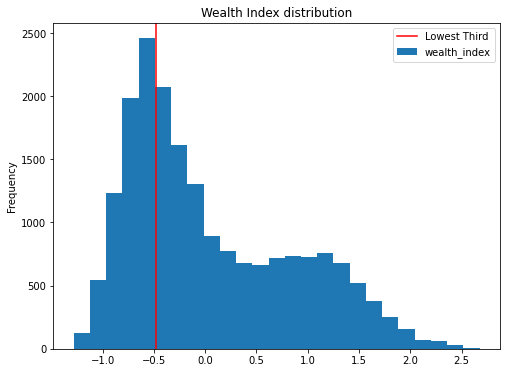

In [ ]:
combined.wealth_index.plot(kind='hist', title='Wealth Index distribution', figsize=(8,6), bins=25);
plt.axvline(x = lower_third, color = 'r', label = 'Lowest Third');
plt.legend();

Notice that this "lowest third" essentially corresponds to everyone at or to the left of the "left peak" of the bimodal wealth distribution.  It is therefore a natural threshold to use for poverty classification.

In [ ]:
#Create a varaible that equals 1 if and only if the village is in the poorest third
combined['is_poorest'] = combined['wealth_index'].map(lambda x : int(x < lower_third) )
combined.head()

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest
index,,,,,,,,
angola_2011_00-0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922,0
angola_2011_00-1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494,0
angola_2011_00-2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085,0
angola_2011_00-3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711,0
angola_2011_00-4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748,0


In [ ]:
combined['is_poorest'].value_counts(normalize=True)

0    0.666667
1    0.333333
Name: is_poorest, dtype: float64

## Export Combined Dataframe

In [ ]:
combined.to_csv('../data/combined_dhs_data.csv', index_label='index')

## Train/test/validate split

We reserve 5% of our data for validation and 5% for testing (to be used only after the modeling process is complete).

In [ ]:
df_train, df_test = train_test_split(combined, random_state=42, test_size=.1)

In [ ]:
df_val, df_test = train_test_split(df_test, random_state=123, test_size=.5)

#### How many data points are in each data set?

In [ ]:
len(df_train), len(df_test), len(df_val)

(17520, 974, 973)

### Export the train/test/validate data sets

In [ ]:
df_train.to_csv('../data/train.csv', index_label='index')

In [ ]:
df_val.to_csv('../data/val.csv', index_label='index')

In [ ]:
df_test.to_csv('../data/test.csv', index_label='index')

# A function to export the RGB images as `.jpg` files and the other image channels as `.png` files

Recall our plan from above:

1. For each observation, check that none of the RBG pixels are "bad" (not between 0 and 1).  Skip these "bad" observations.
2. For every non-"bad" observation, export the RBG channels as a single RGB image (in `.jpg` format, with values between 0 and 255).  Then export all the other channels as individual single-channel images (in `.png` format, so that things automatically rescale to be between 0 and 1).

Furthermore, we will want to do the following things as we export our files:
3. Automatically split the data into `train`, `test`, and `val` directories so that `keras` has an easy time with things.
4. Within each of the `train`, `test` and `val` directories, split the images among two folders: folder `1` representing the poorest third of all villages (equivalent to `is_poorest==1` below), and folder `0` representing all other villages.

Now that we have determined exactly which observations have "all good" RGB pixels, and now that we have included an indicator variable `is_poorest` in each dataframe and performed a train/test/validate split, it should be easy to write a function that performs the tasks above.

In [ ]:
def export_good_images_separated(input_directory, filename, img_output_dir,
                                 train_df, test_df, val_df):
    '''
    Inputs:
    -input_directory: Path to folder containing .tfrecord.gz file to be processed
    -filename: Name of file to be processed (do NOT include a '/' or .tfrecord.gz)
    -img_output_dir: Path to folder to output the images to.  This folder should
      contain subfolders named 'RGB', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1' and
      'NIGHTLIGHTS'.  Each of these should itself contain subfolders named 'train',
      'test' and 'val'.  Finally, each of the train, test and val folders should
      contain subfolders named '0' and '1'.
    -train_df: a Pandas dataframe of the observations that you want to be exported
      into the "train" folders.  The index of this dataframe should contain entries
      of the form '[name of .tfrecord.gz file, without the extension]-[obs #]' where
      [obs #] represents the index of that observation in the .tfrecord.gz file
      from which it originally came.  Furthermore, the dataframe must contain
      a column labeled `is_poorest` that takes on values 0 and 1 (corresponding to
      whether that observation is in the poorest third of all admissible villages)
    -test_df: The same as train_df, but for the images you want exported to the
      "test" folders
    -val_df: The same as train_df, but for the images you want exported to the
      "val" folders

    Extracts the 8 image channels from each record in the given .tfrecord.gz
      file (ignores LAT and LON). The name of each image will be the same as the
      inputted 'filename' but with an appended '-[indexnumber].jpg' (for RGB
      images) or '-[indexnumber].png' (for all other images channels),
      where [indexnumber] is the index of that image in the inputted .tfrecord.gz
      file.

      If any image does not correspond to the index of one of the inputted
      dataframes train_df, test_df or val_df, then it is skipped and none
      of its channels are exported.
    '''
    tfrecord_path = f"{input_directory}/{filename}.tfrecord.gz"
    feature_maps = get_all_feature_maps(tfrecord_path)

    #Do not extract the LAT and LON channels
    rgb_channels = ['RED','GREEN','BLUE']
    non_rgb_channels = ['NIR', 'SWIR1', 'SWIR2', 'TEMP1', 'NIGHTLIGHTS']

    for ind in range(len(feature_maps)):

        #Find out if this index corresponds to a train, test, or val observation
        name = f"{filename}-{ind}"
        category = 'skip'

        if name in train_df.index:
            category = 'train'
            is_poorest = train_df.loc[name]['is_poorest']
        elif name in test_df.index:
            category = 'test'
            is_poorest = test_df.loc[name]['is_poorest']
        elif name in val_df.index:
            category = 'val'
            is_poorest = val_df.loc[name]['is_poorest']

        #If this observation doesn't appear in any of these dataframes, we know
        #it had bad RGB pixles.  So we'll skip it.
        if category == 'skip':
            continue

        #Otherwise, extract the image information and store it in the right folder


        #First, the RGB channels
        rgb_arrays_list = []

        for channel in rgb_channels:
            #Get a 1-D array of all the pixels in this channel
            channel_array = np.asarray( [feature_maps[ind][channel].float_list.value[i] for i in range(65025)] )
            #Append this color's array to our list of rgb channel arrays, after reshaping into 255x255
            rgb_arrays_list.append( channel_array.reshape(255,255) )

        #Stack them into one 255x255x3 array
        img_array = np.stack(rgb_arrays_list, axis=2)
        #Save this RGB image as a .jpg in the appropriate folder
        plt.imsave(f"{img_output_dir}/RGB/{category}/{is_poorest}/{name}.jpg", img_array)


        #Next, the non-RGB channels
        for channel in non_rgb_channels:
            channel_array = np.asarray( [feature_maps[ind][channel].float_list.value[i] for i in range(65025)] )
            #These channels are all exported individually as their own images
            img_array = channel_array.reshape(255,255)
            plt.imsave(f"{img_output_dir}/{channel}/{category}/{is_poorest}/{name}.jpg", img_array)


## Use the function to process a single `.tfrecord.gz` file

In [ ]:
#Use the same .tfrecord.gz file as before
input_directory = '../data/dhs_tfrecords_raw'
filename = 'angola_2011_00'

#Output to the "separated" folders this time
img_output_dir = '../data/dhs_images_separated'

In [ ]:
export_good_images_separated(input_directory = input_directory,
                             filename = filename,
                             img_output_dir = img_output_dir,
                             train_df = df_train,
                             test_df = df_test,
                             val_df = df_val
                             )

Checking the outputted files, they all look good!  So we can proceed to using the function to process *all* the `.tfrecord.gz` files:

## Using the function to process ALL the `.tfrecord.gz` files (this will take about 4-4.5 hours)

In [ ]:
#Recall the list we already made of all the .tfrecord.gz files' names
print(len(tfrecords))
tfrecords[:5]

85


['angola_2011_00',
 'malawi_2012_00',
 'cote_d_ivoire_2012_00',
 'malawi_2014_00',
 'ghana_2016_00']

We've already processed `angola_2011_00`, so now we only need to process the others:

In [ ]:
todo = [ x for x in tfrecords if x!='angola_2011_00']
print(len(todo))
todo[:5]

84


['malawi_2012_00',
 'cote_d_ivoire_2012_00',
 'malawi_2014_00',
 'ghana_2016_00',
 'cameroon_2011_00']

In [ ]:
input_directory = '../data/dhs_tfrecords_raw'

img_output_dir = '../data/dhs_images_separated'

In [ ]:
#Use the function - this will take several hours
for file_name in todo:
    export_good_images_separated(input_directory = input_directory,
                             filename = file_name,
                             img_output_dir = img_output_dir,
                             train_df = df_train,
                             test_df = df_test,
                             val_df = df_val
                             )

## What's next?

In the [next notebook](03_EDA.ipynb), we explore the non-image data's basic features.  In [the notebook after that](04_Baseline_model.ipynb), we build baseline models to predict whether a given village is in the poorest third of all villages using only the non-image data.  In the [second-to-last notebook](05_nn_modeling.ipynb), we use Convolutional Neural Networks to process the 6 types of images exported in this notebook and extract predictions for each village from each type of image.  Finally, in the [last notebook](06_final_modeling.ipynb) we combine these predictions with the non-image data to develop a production model.